In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements, and eventually radial velocity measurements (in the next tutorial, :ref:`astrometric-rv`). For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [4]:
# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01"$ for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [6]:
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns

rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

# Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

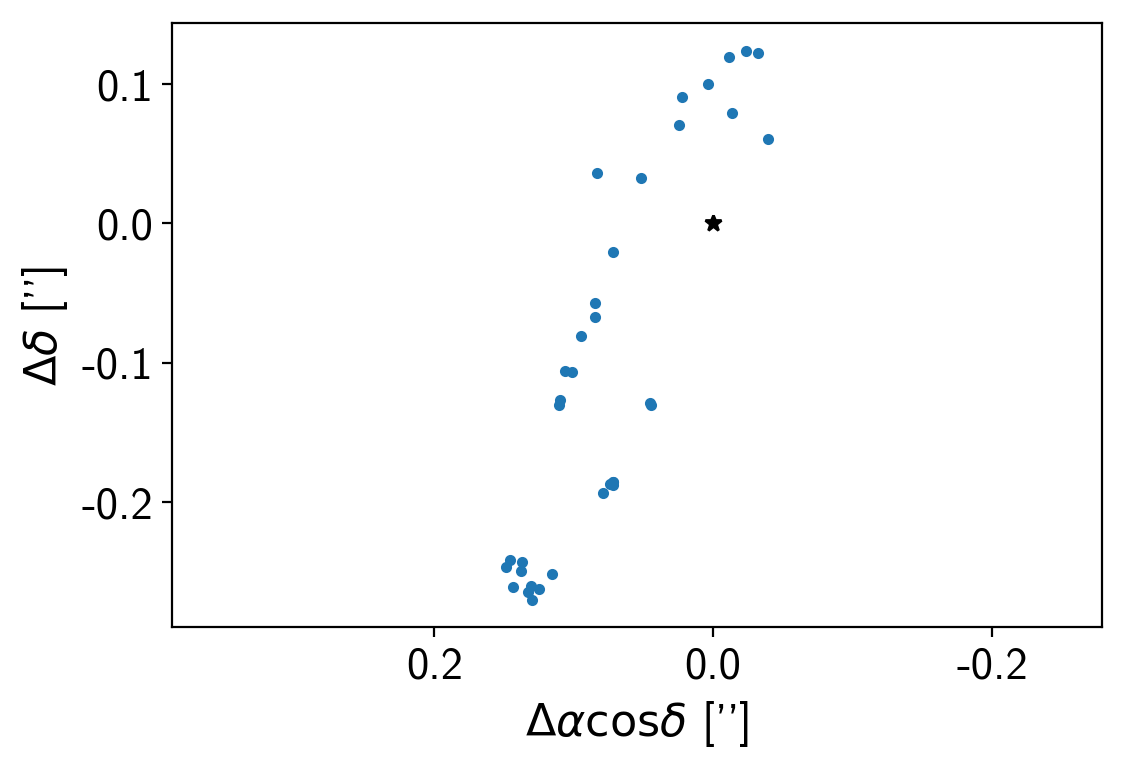

In [7]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left

fig, ax = plt.subplots(nrows=1)

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

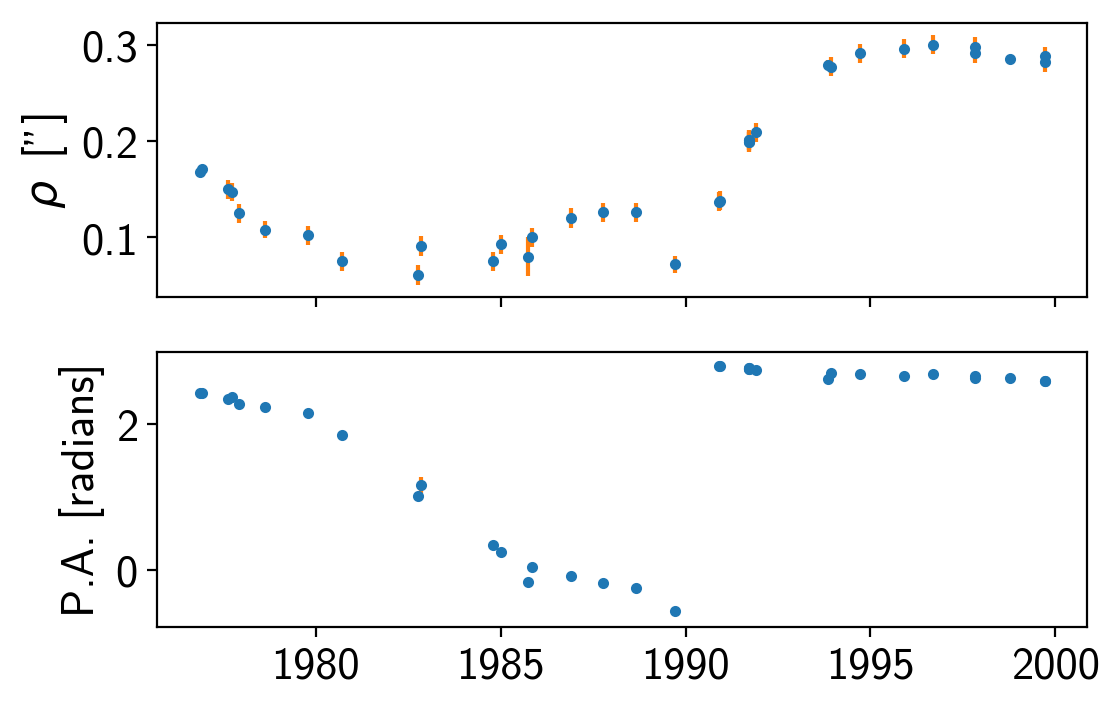

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(astro_yrs, rho_data, ".")
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, ".")
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

# Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

In [9]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

## A note on setting the scale of an orbit 

Orbits in *exoplanet* generally specify the semi-major axis in units of solar radii `R_sun`. For transits and RV orbits, you usually have enough external information (e..g., estimate of stellar mass from spectral type) to put a physical scale onto the orbit. For the most basic of astrometric orbits without parallax information, however, this information can be lacking and thus it makes sense to fit for the semi-major axis in units of `arcseconds`. But, `exoplanet` is modeling a real orbit (where semi-major axis is in units of `R_sun`), so we do need to at least provide a fake parallax to convert from arcseconds to `R_sun.`

In [11]:
# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

In [12]:
# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324 # arcsec
parallax = 1 # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

# n = 2 * np.pi / P
# t0 = (phi + w) / n

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega)

# make a theano function to get stuff from orbit 
times = tt.vector("times")

# pos = orbit.get_relative_position(times) # the X, Y, Z coordinates
# the position functions take an optional argument parallax to convert from physical units back to arcseconds
ang = orbit.get_relative_angles(times, parallax) # the rho, theta coordinates

# f_pos = theano.function([times], pos)
f_ang = theano.function([times], ang)

t = np.linspace(T0 - P, T0 + P, num=200) # days

# # anoms = f_anom(t)
# X, Y, Z = f_pos(t)
rho, theta = f_ang(t)

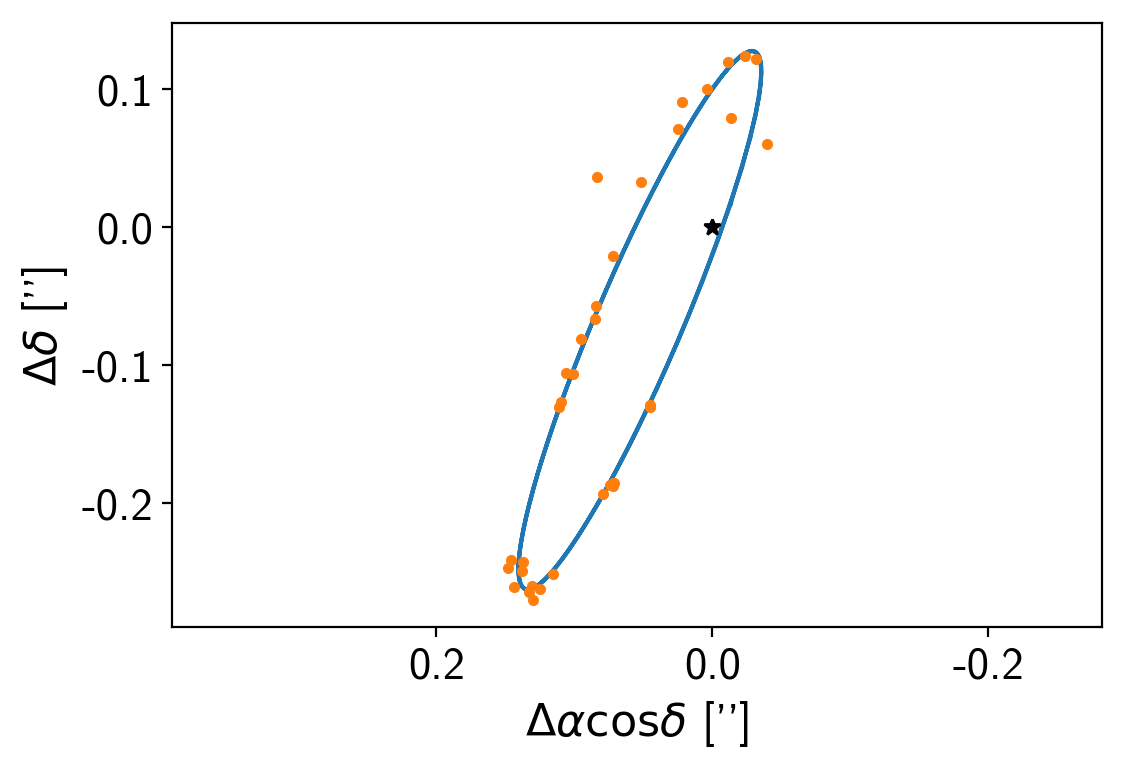

In [13]:
fig, ax = plt.subplots(nrows=1)

# plot the orbit 
xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

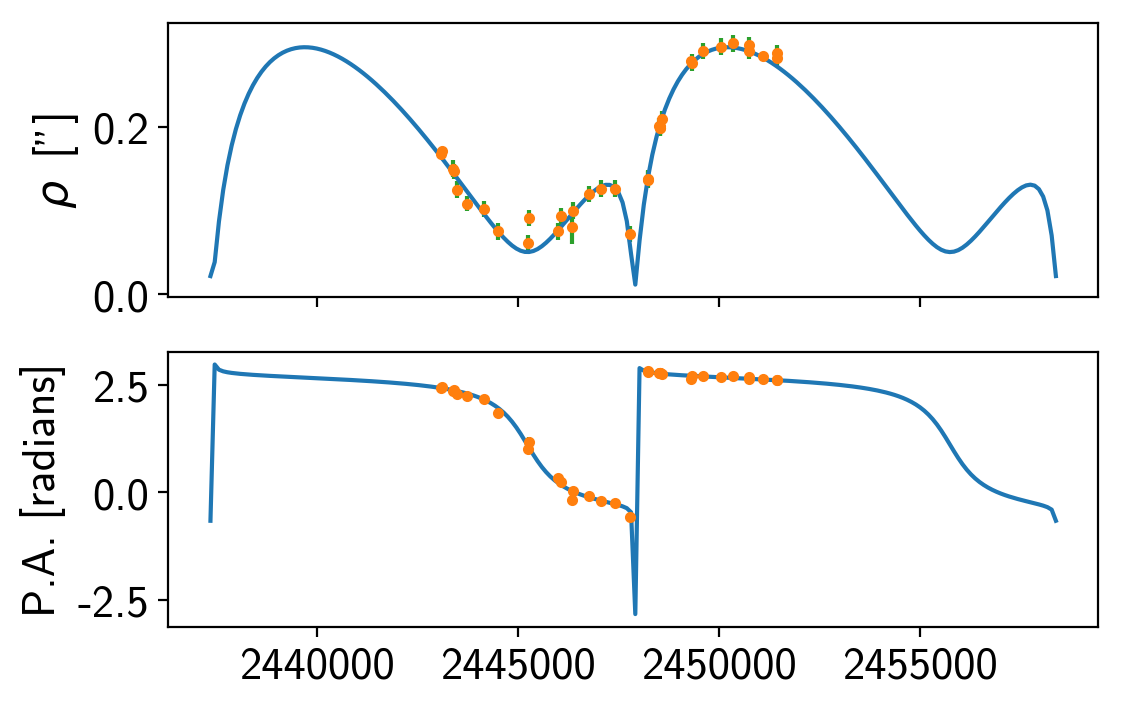

In [14]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, rho)
ax[0].plot(astro_jds, rho_data, ".")
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta)
ax[1].plot(astro_jds, theta_data, ".")
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

In [15]:
# Set up the model in PyMC3

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)

with pm.Model() as model:

    # A setup for a basic astrometric binary orbit
    # without an actual parallax measurement, we can model the orbit in units of arcseconds
    # by providing a fake_parallax and conversion constant
    parallax = 1 # arcsec 
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
    a = pm.Deterministic("a", a_ang * au_to_R_sun / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP))
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform prior on cos_incl (geometric)
    cos_incl = pm.Uniform("cosIncl", lower=-1, upper=1, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    orbit = xo.orbits.KeplerianOrbit(a=a, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)
    
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
    
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # define the likelihood function, e.g., a Gaussian on both rho and theta
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    
    # n.b. that we want to be cognizant of the fact that theta wraps 
    # so the following is equivalent to 
    # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
    # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)
    
    # set up predicted orbits for later plotting 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    

In [16]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'logP_interval__', 'a_ang_interval__']
message: Optimization terminated successfully.
logp: 105.56753460346393 -> 195.2850833759545


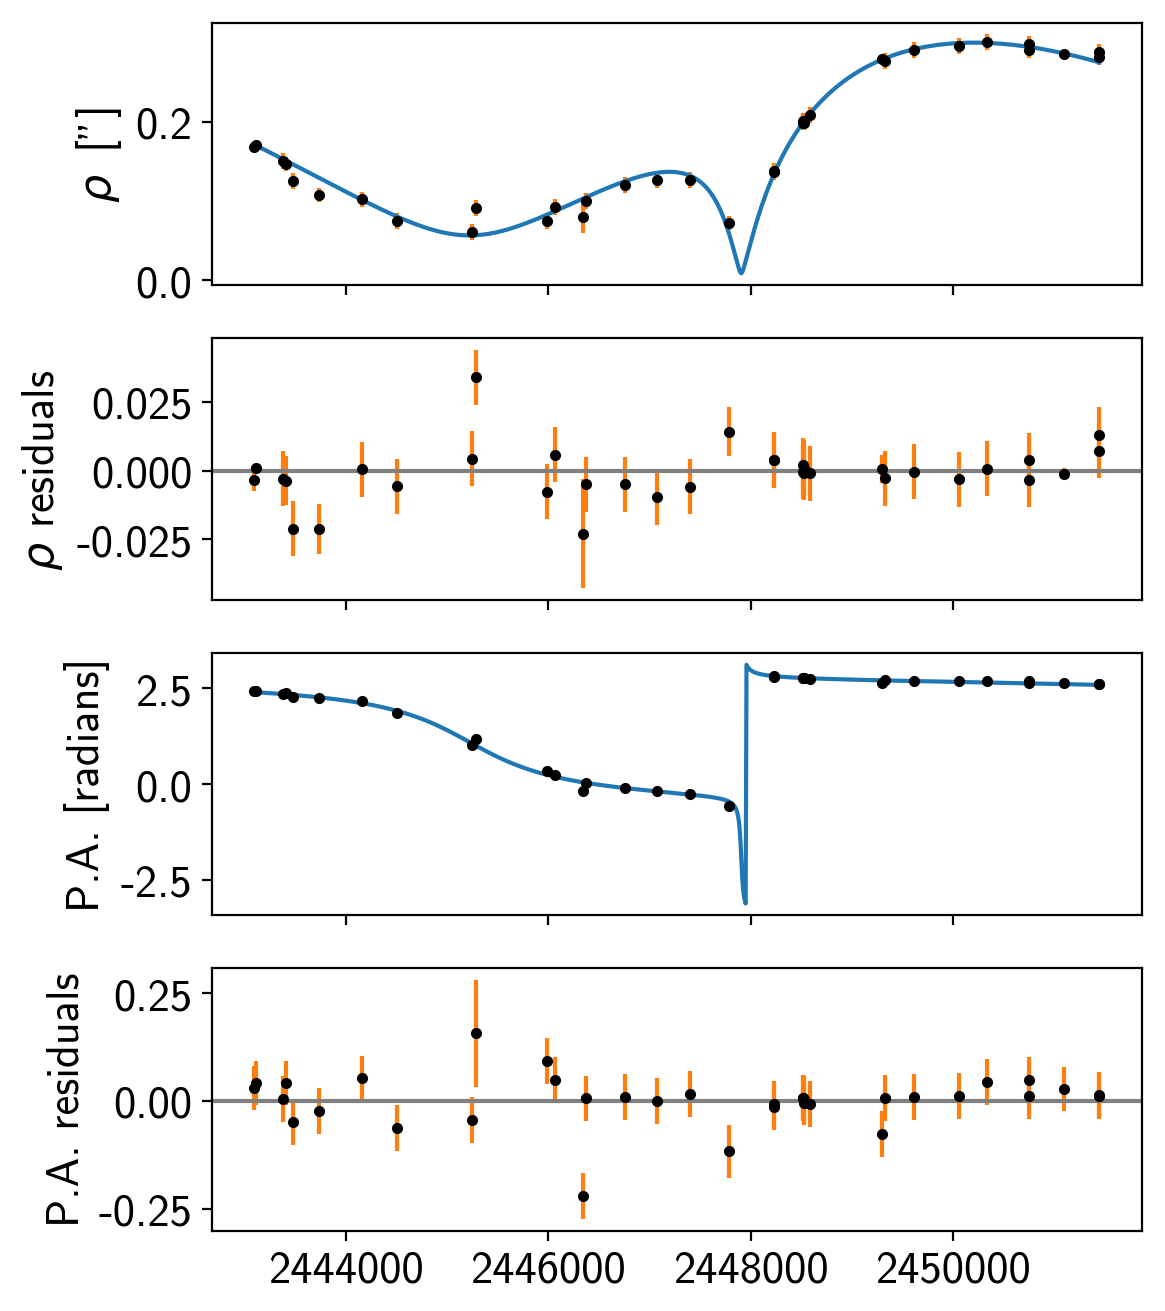

In [18]:
# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

with model:
    tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_sol["logRhoS"]))
    tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_sol["logThetaS"]))
        
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
    ax[1].axhline(0.0, color="0.5")
    ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), **pkw)
    ax[1].errorbar(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), yerr=tot_rho_err, **ekw)
    
        
    ax[2].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[2].plot(astro_jds, theta_data, **pkw)
    ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
    ax[3].axhline(0.0, color="0.5")
    ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), **pkw)
    ax[3].errorbar(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), yerr=tot_theta_err, **ekw)   

In [19]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains: 100%|██████████| 1208/1208 [00:04<00:00, 266.48draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, logP, a_ang]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:44<00:00, 359.69draws/s]


/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fcc53c8>,
      dtype=object)

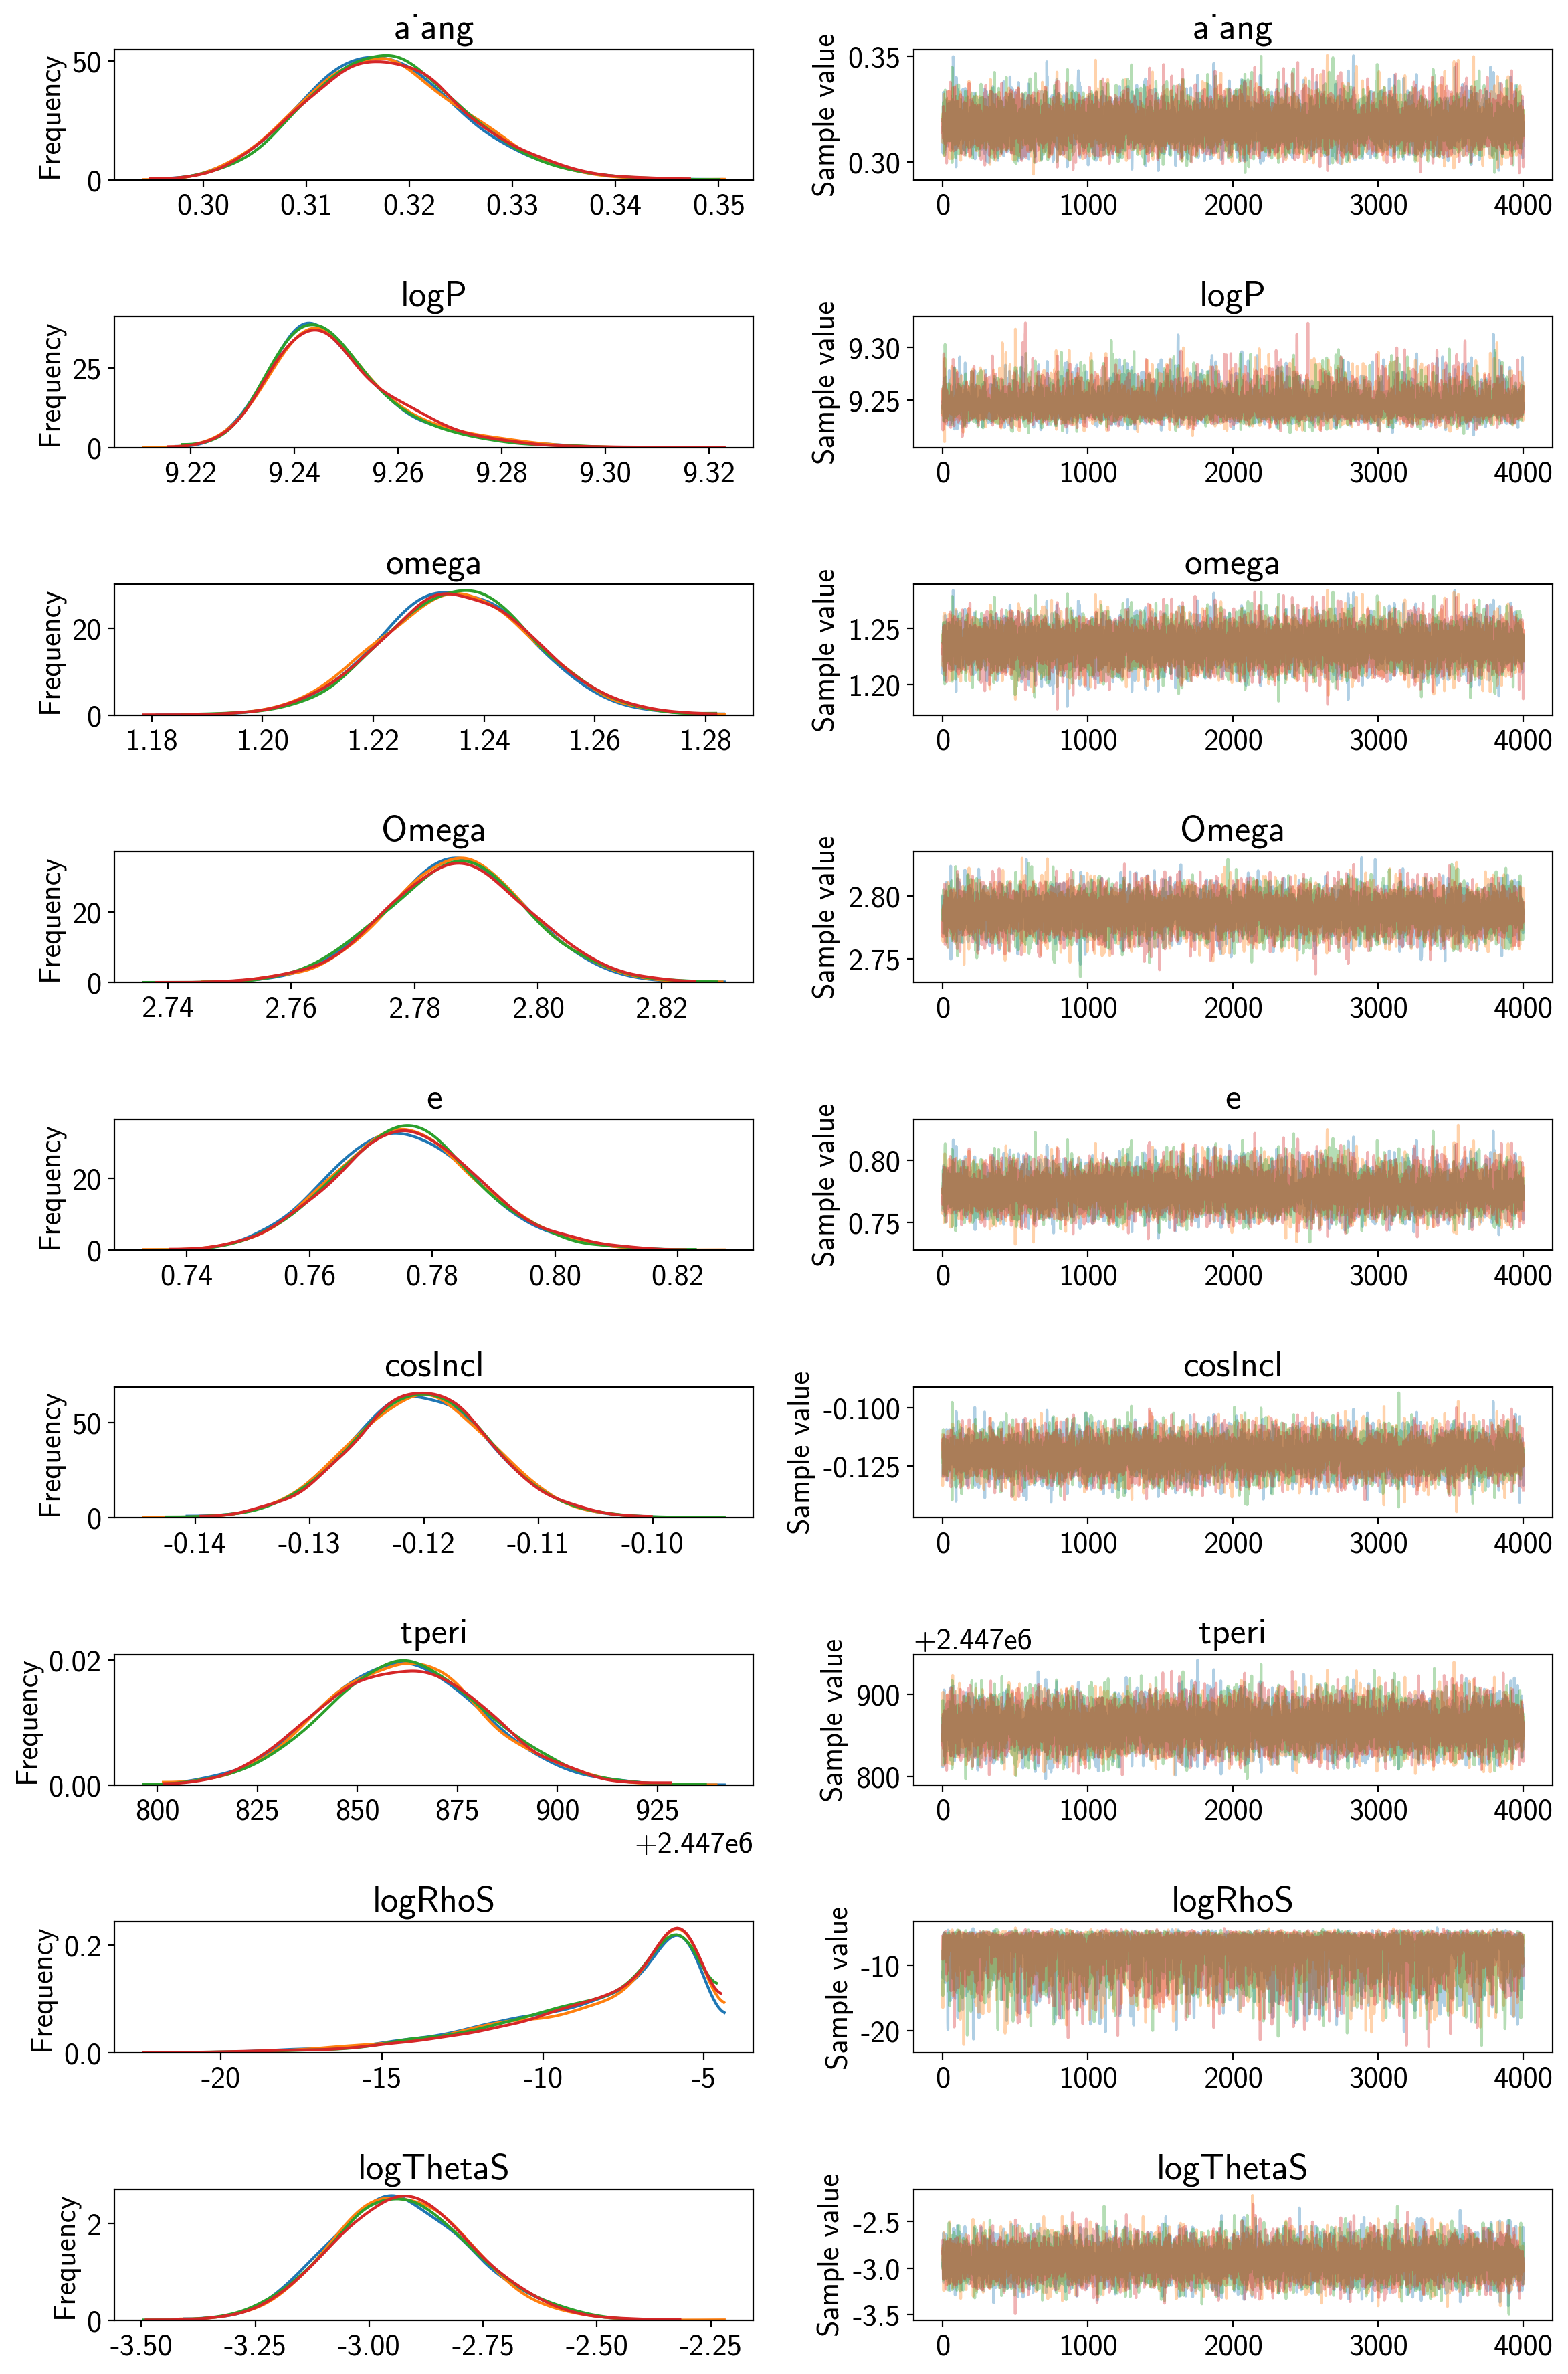

In [20]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", "logRhoS", "logThetaS"])

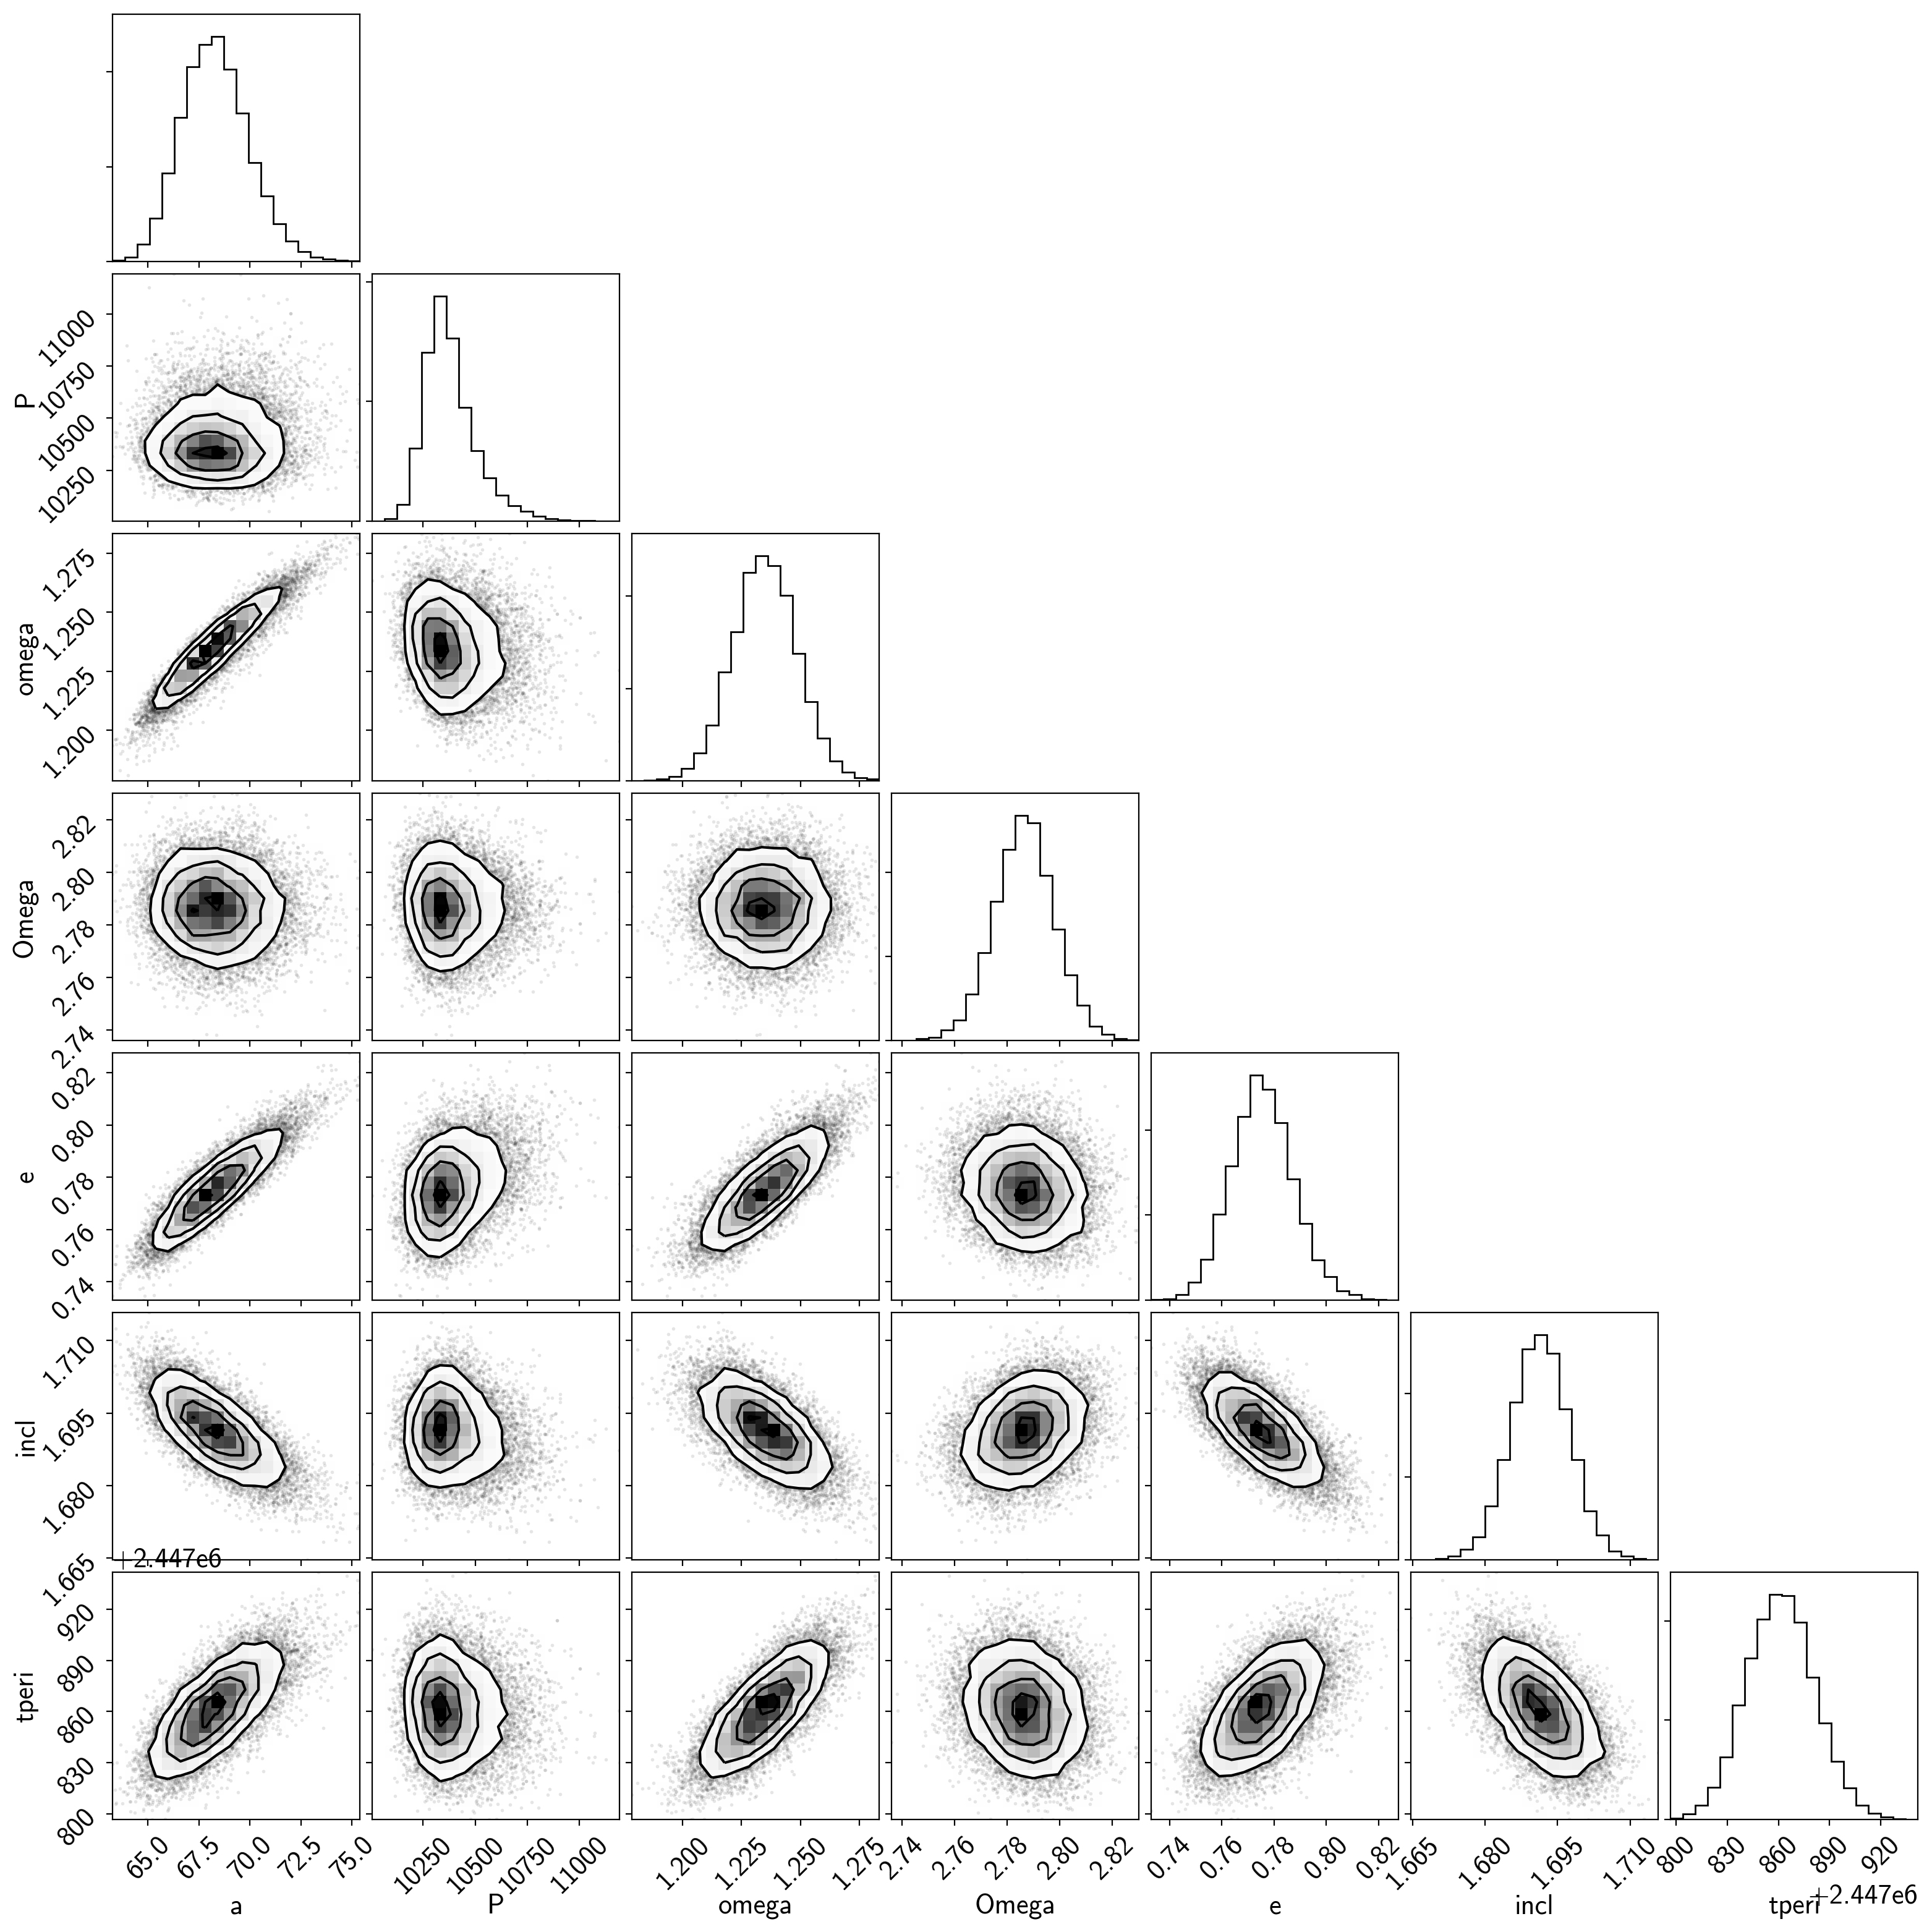

In [21]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["a", "P", "omega", "Omega", "e", "incl", "tperi"])
corner.corner(samples);

Great, it looks like we have a converged posterior, and in a pretty reasonable amount of time too. The semi-major axis and $\omega$ are quite correlated, which underscores the need for using the tuning schedule.


Note that there is also another (degenerate) solution at $\Omega + \pi$ and $\omega + \pi$ that we've missed, because we initialized the sampler deep in the potential well of our preferred peak. If you really do have an astrometric-only orbit, for this reason it can more efficient to sample in $p = \Omega + \omega$ and $m = \Omega - \omega$, since these will yield unambiguous constraints on $p$ and $m$, and $\Omega$ and $\omega$ can be backed out of them.

Let's plot the data with draws of the potential orbit, which we saved during the sampling of the model.

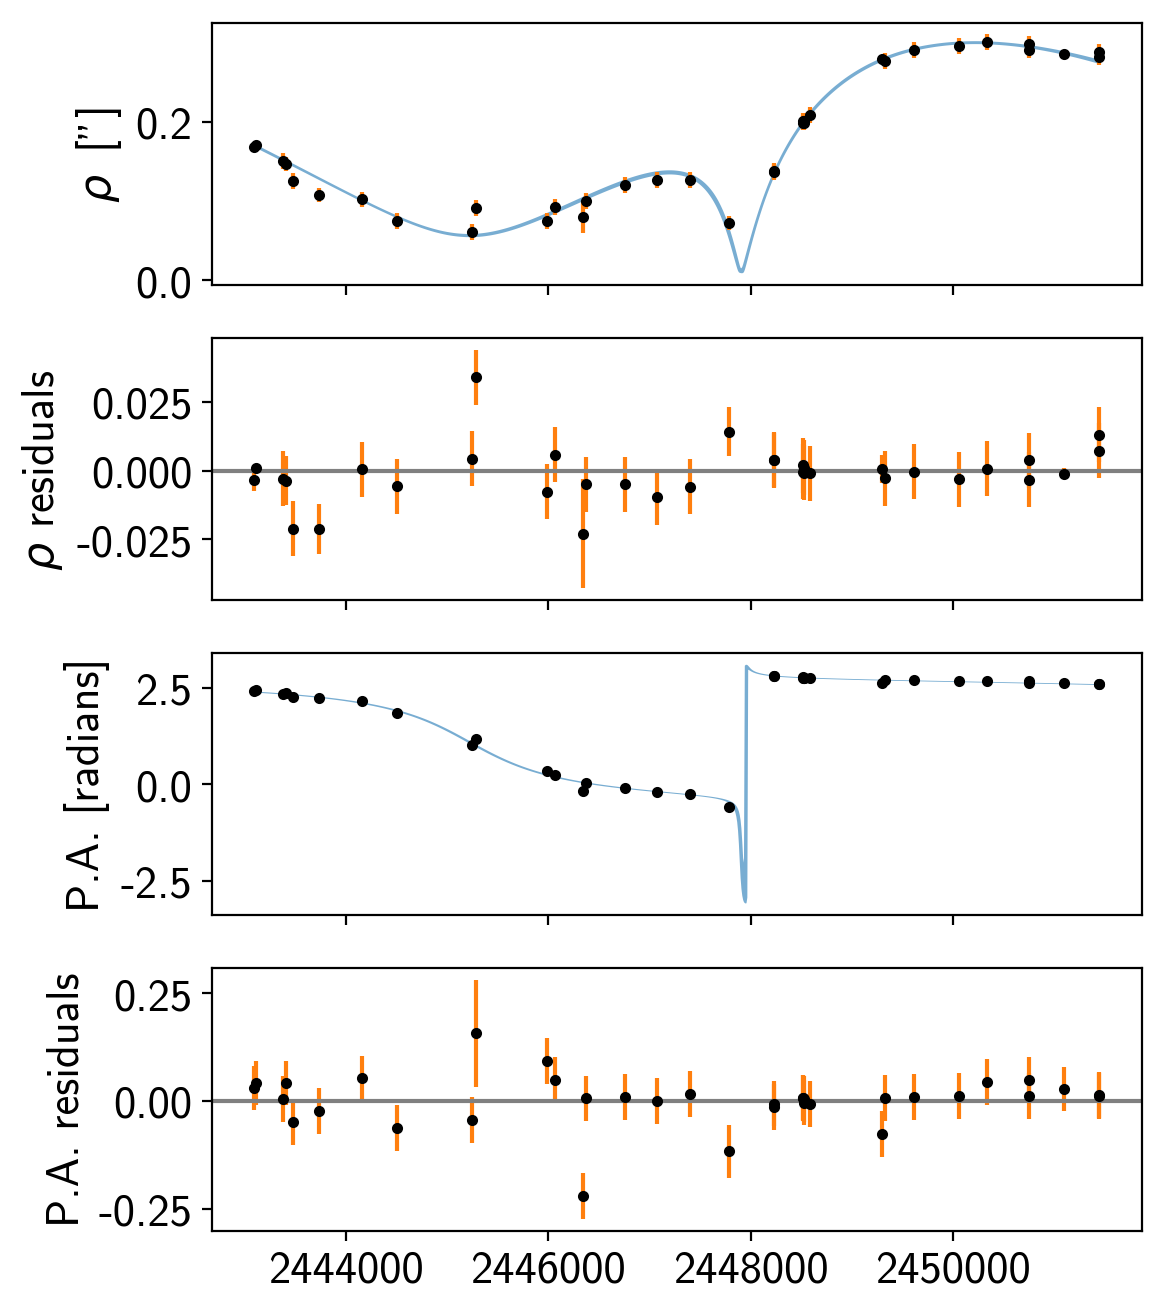

In [23]:
# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

# Compute the posterior predictions for the RV model
rho_pred = np.percentile(trace["rhoSave"], [16, 50, 84], axis=0)
theta_pred = np.percentile(trace["thetaSave"], [16, 50, 84], axis=0)

with model:
    tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_sol["logRhoS"]))
    tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_sol["logThetaS"]))
        
        
    art = ax[0].fill_between(t_fine, rho_pred[0], rho_pred[2], color="C0", alpha=0.6)
    art.set_edgecolor("none")

    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
    ax[1].axhline(0.0, color="0.5")
    ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), **pkw)
    ax[1].errorbar(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), yerr=tot_rho_err, **ekw)
    
    art = ax[2].fill_between(t_fine, theta_pred[0], theta_pred[2], color="C0", alpha=0.6)
    art.set_edgecolor("none")

    ax[2].plot(astro_jds, theta_data, **pkw)
    ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
    ax[3].axhline(0.0, color="0.5")
    ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), **pkw)
    ax[3].errorbar(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), yerr=tot_theta_err, **ekw) 

As we can see from the narrow range of orbits (the blue swath appears like a thin blue line), the orbit is actually highly constrained by the astrometry. We also see two clear outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit. It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points. We can address these with a jitter model.

# Orbital fit with parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.


In [24]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [56]:
# Set up the model in PyMC3

with pm.Model() as parallax_model:

    # A setup for a basic astrometric binary orbit
    # We'll include the parallax data as a prior on the parallax value 
    
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec 
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

In [57]:
with parallax_model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'logP_interval__', 'a_ang_interval__', 'mparallax']
message: Optimization terminated successfully.
logp: 105.44710376647718 -> 195.16465253896757


In [59]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with parallax_model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains: 100%|██████████| 1208/1208 [00:04<00:00, 267.82draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, logP, a_ang, mparallax]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:39<00:00, 408.43draws/s]


/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3026c278>,
      dtype=object)

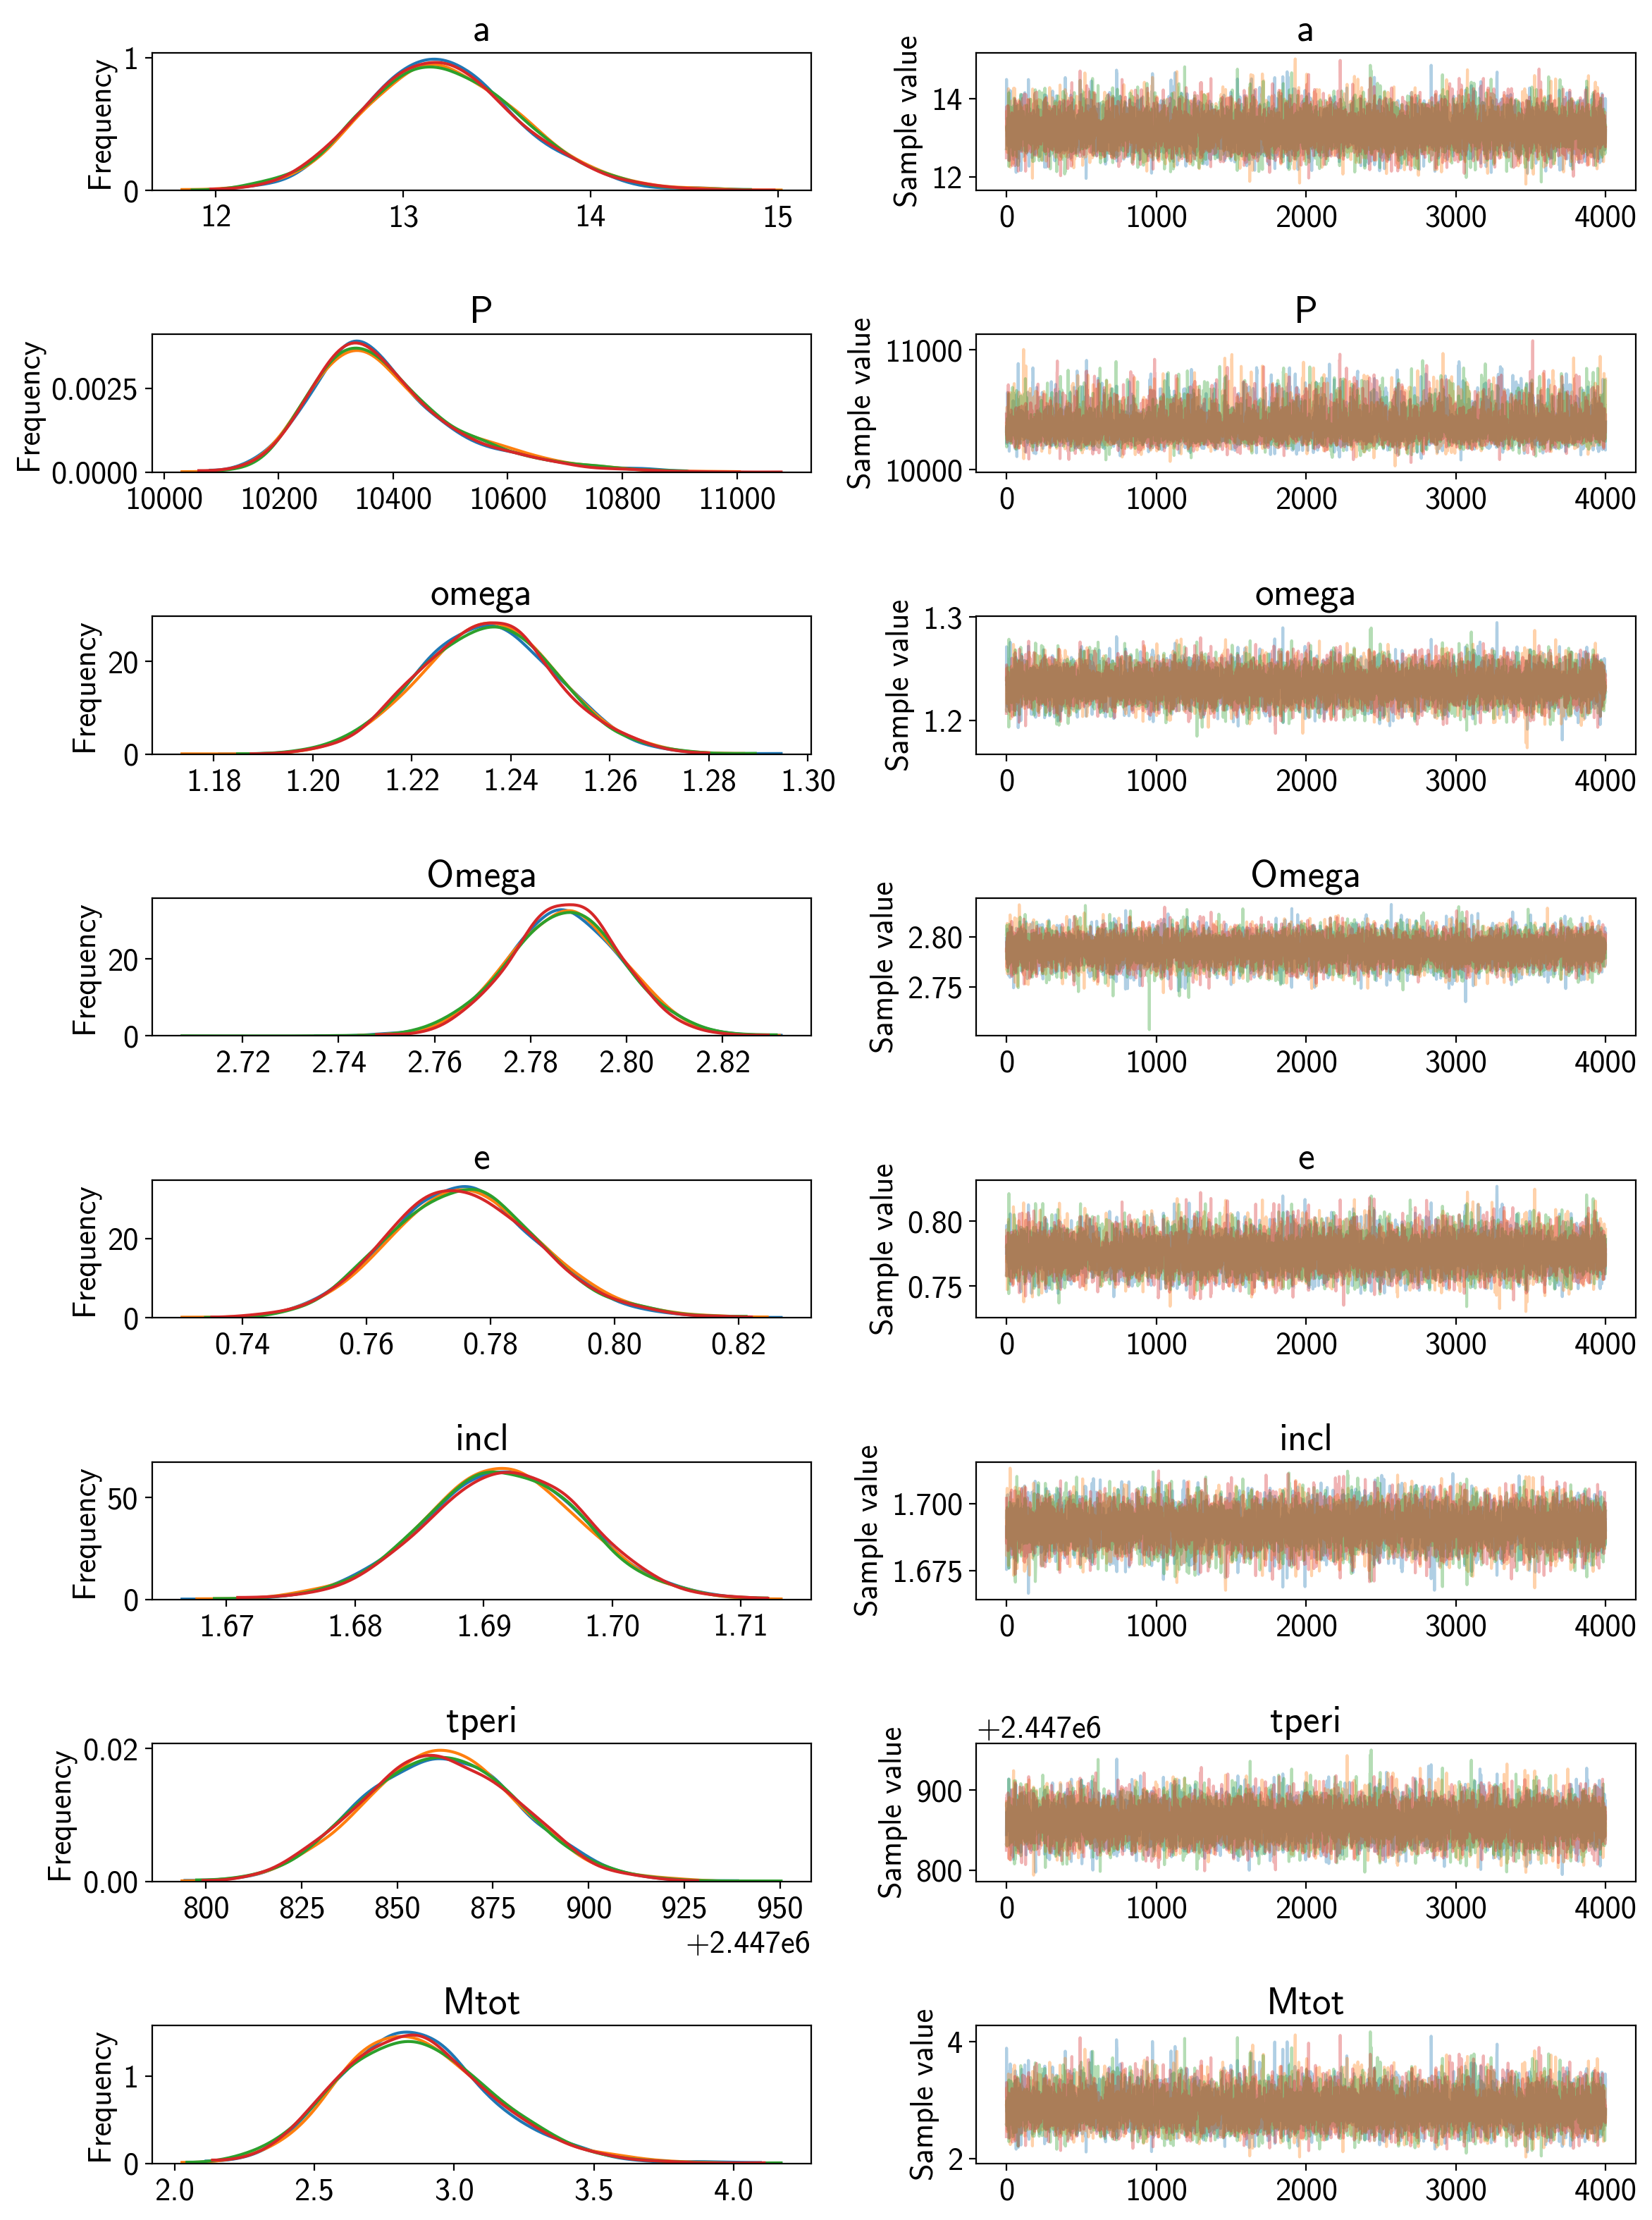

In [60]:
pm.traceplot(trace, varnames=["a", "P", "omega", "Omega", "e", "incl", "tperi", "Mtot"])

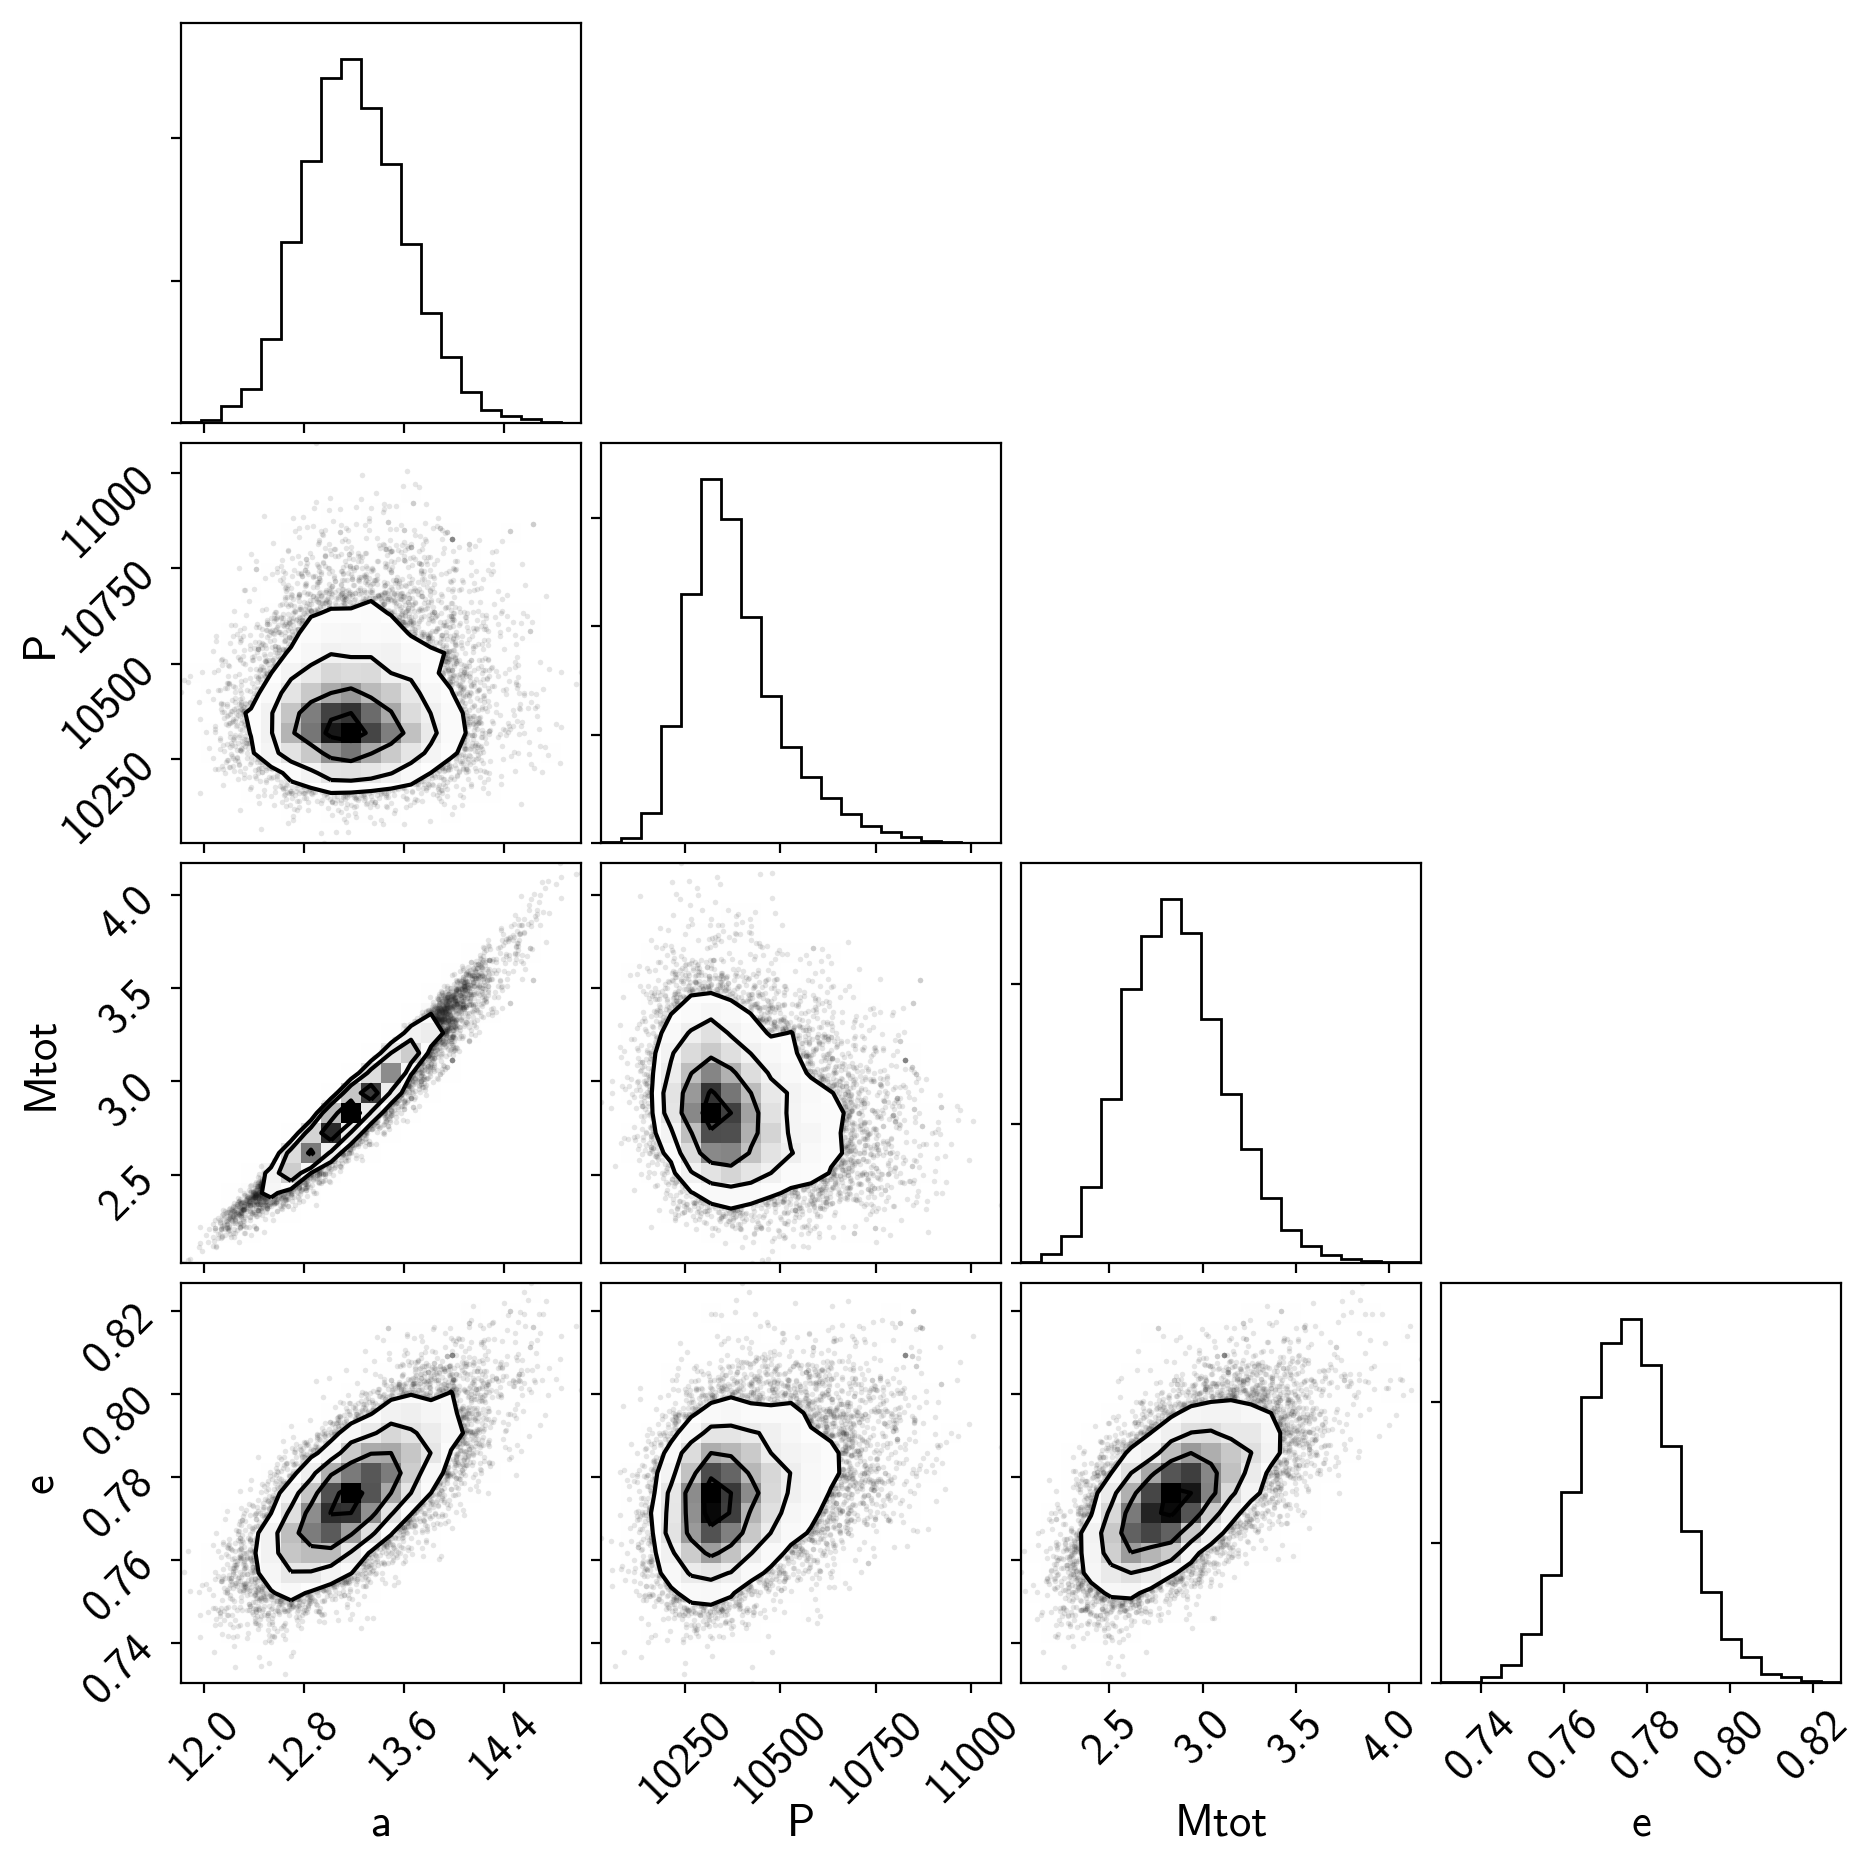

In [61]:
samples = pm.trace_to_dataframe(trace, varnames=["a", "P", "Mtot", "e"])
corner.corner(samples);